In [1]:
import numpy as np
from scipy.special import rel_entr
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm

$$
Z = \sum_{i=1}^{|\tau_r|}\frac{1}{\mbox{log}_2 (i+1)}
$$

$$
NDKL(\tau_r) = 
\frac{1}{Z}
\sum_{i=1}^{|\tau_r|}
\frac{1}{\mbox{log}_2(i+1)}
d_{KL}(D_{\tau_r^i} || D_r)
$$

In [2]:
def kl_divergence(p, q):    
    return np.sum([rel_entr(p[i], q[i]) for i in range(len(p))])     

In [3]:
def normalizer(n):
    '''
    find normalizer Z for a ranking with n elements
    '''
    return np.sum([1/math.log2(i+1) for i in range(1, n+1)])

In [4]:
def NDKL(ranking, protected_indeces, target_proportion):
    Q = np.array([target_proportion, 1 - target_proportion])
    
    partial_sum = 0    
    for i in range(1, len(ranking)):        
        protected_proportion = len(set(ranking[:i]).intersection(protected_indeces)) / i        
        P = np.array([protected_proportion, 1 - protected_proportion])                
        partial_sum += kl_divergence(P, Q) / math.log2(i+1)
    Z = normalizer(len(ranking))    
    return partial_sum / Z    

In [5]:
results = {}

In [6]:
test_0 = 'Moving single protected element' 
tests = ['Favoring protected group (p=1)',
         'Favoring nonprotected group (p=0)',
         'Random positions over 100 runs',
         'Sequential maintaining p=0.5']

In [7]:
def plot(r, title):
    fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10,6), constrained_layout=True)
    axes = axes.ravel()

    fig.text(0.5, -0.05, 'Proportion of protected group', ha='center')
    fig.text(-0.01, 0.5, 'Fairness Score', va='center', rotation=90)

    for i, test in enumerate(tests):
        axes[i].plot(list(range(100)), r[test])
        axes[i].set_title(test)
        axes[i].grid()
        axes[i].set_ylim(-0.2, 1)

    fig.suptitle(title, fontsize=16)
    plt.savefig('geyik2019fairness.png', bbox_inches='tight')
    plt.show()  

In [8]:
ranking = list(range(100))

In [9]:
results_0 = [NDKL(ranking, [i], .01) for i in range(100)]

In [10]:
pro_index = [x for x in range(100)]
scores = []
for i in range(100):
    scores.append(NDKL(ranking, pro_index[:i], i / 100))
    
results[tests[0]] = scores

In [11]:
pro_index = [x for x in range(100)][::-1]
scores = []
for i in range(100):
    scores.append(NDKL(ranking, pro_index[:i], i / 100))

results[tests[1]] = scores

In [12]:
runs = 100

scores = np.zeros((100, 100))

for i in tqdm(range(runs)):
    pro_index = random.sample(range(100), 100)
    for j in range(100):
        scores[i][j] = NDKL(ranking, pro_index[:j], j / 100)

results[tests[2]] = np.mean(scores, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


In [13]:
pro_index = [x for x in range(0, 100, 2)] + [x for x in range(1, 100, 2)]
scores = []
for i in range(100):
    scores.append(NDKL(ranking, pro_index[:i], i / 100))
    
results[tests[3]] = scores

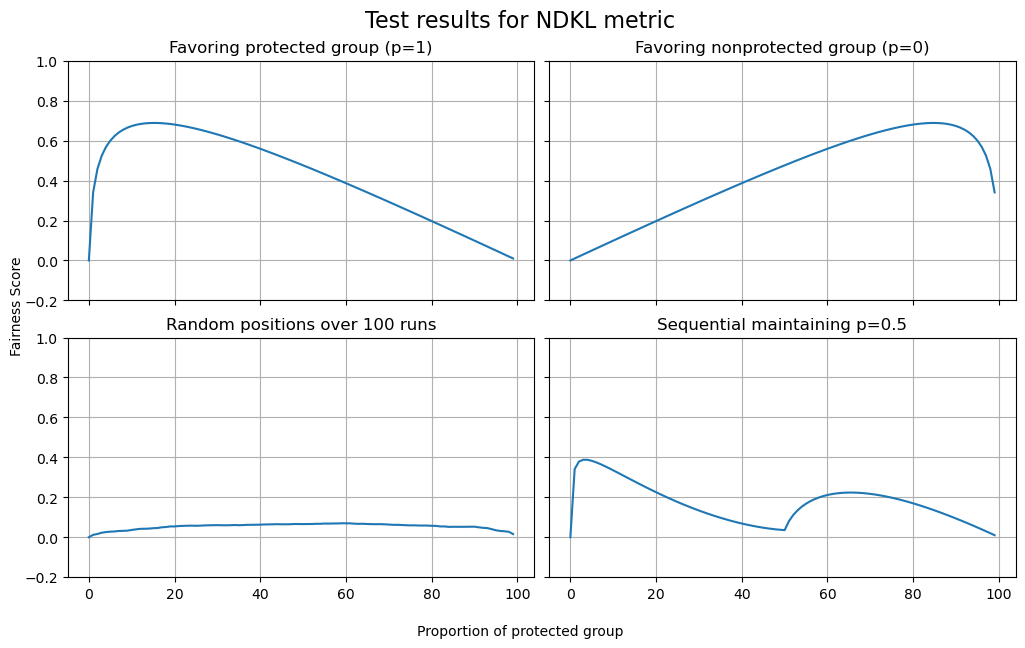

In [14]:
plot(results, 'Test results for NDKL metric')

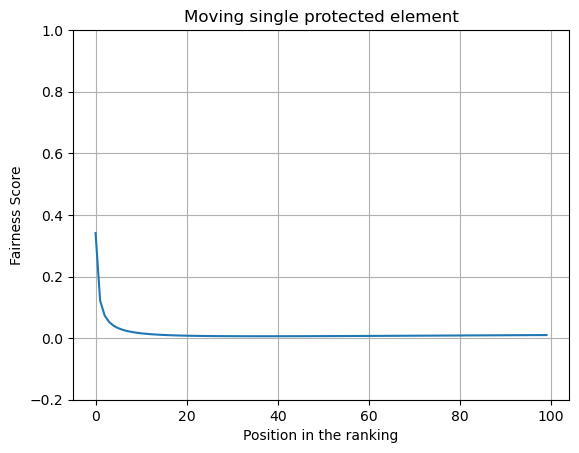

In [17]:
plt.plot(list(range(100)), results_0)
plt.title(test_0)
plt.grid()
plt.ylim(-0.2, 1)
plt.ylabel('Fairness Score')
plt.xlabel('Position in the ranking')
plt.savefig('geyik2019fairness_1.png', bbox_inches='tight')
plt.show() 